In [1]:
# TODO: clean imports
import numpy as np
import pandas as pd
from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.ensemble import RandomForestClassifier


from ollama import chat
from ollama import embeddings
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)
# import torch
# import torch.nn as nn
# import pytorch_lightning as pl
# from torch.utils.data import DataLoader, TensorDataset
# from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
# import torchmetrics

import os
from glob import glob
from pathlib import Path
from tqdm.notebook import tqdm
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib import pyplot as plt

from modules import *

# override all pandas display limits
pd.options.display.max_columns = None
pd.options.display.max_rows = None



In [2]:
# load parquet files
data_path = Path("../../data")
notebooks_path = Path(os.getcwd())
data_dir = {}

##unsafe
# for file_path in list((notebooks_path / data_path).glob("*.parquet")):
#     print(f"Reading {file_path}")
#     # retrieve the name of the file without the extension for all OS
#     data = pd.read_parquet(file_path)
#     # if "Time" in df.columns:
#     #     df["Time"] = pd.to_datetime(df["Time"])
#     data_dir[str(file_path).replace("\\", "/").split("/")[-1].split(".")[0].replace("-", "_")] = data

for file_path in (notebooks_path / data_path).glob("set*.parquet"):
    var_name = file_path.stem.replace("-", "_")
    globals()[var_name] = pd.read_parquet(file_path)
    print(f"Reading {file_path} -> {var_name}")


ID_vars = ["PatientID", "Time", "RecordID"]
# stationary variables
stationary_vars = ["Age", "Gender", "Height"] #, "ICUType"]
# dynamic variables
dynamic_vars = set_a.columns.difference(stationary_vars + ID_vars).tolist()


Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-a-filled.parquet -> set_a_filled
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-b.parquet -> set_b
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-a.parquet -> set_a
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-c-filled.parquet -> set_c_filled
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-c.parquet -> set_c
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-b-filled.parquet -> set_b_filled


In [3]:
# for key in ["a", "b", "c"]:
#     print(f"Extracting set_{key}") 
#     df = extract_features(globals()[f"set_{key}_filled"])
#     df.to_csv(notebooks_path / data_path / Path(f"features_{key}.csv"))

In [4]:
for file_path in (notebooks_path / data_path).glob("features*.csv"):
    var_name = file_path.stem.replace("-", "_")
    globals()[var_name] = pd.read_csv(file_path)
    print(f"Reading {file_path} -> {var_name}")

Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/features_a.csv -> features_a
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/features_c.csv -> features_c
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/features_b.csv -> features_b


In [5]:
# Train a Random Forest to check feature importance for classification
def split_labels_and_features(df):
    exclude = ["In-hospital_death", "RecordID", "Unnamed", "ICUType"]
    labels = df['In-hospital_death_mean']
    features = df.loc[:, ~df.columns.str.contains("|".join(exclude))].copy()

    return features, labels

# ## top k features
# top_k_features = 20

# X_train, y_train = split_labels_and_features(features_a)

# # Assuming you've already trained your Random Forest
# rf = RandomForestClassifier(n_estimators=100, random_state=42)
# rf.fit(X_train, y_train)

# # Extract importances
# importances = rf.feature_importances_

# # Create a sorted DataFrame
# feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"f{i}" for i in range(X_train.shape[1])]
# importance_df = pd.DataFrame({
#     "Feature": feature_names,
#     "Importance": importances
# }).sort_values(by="Importance", ascending=False)

# # Print top features
# print(importance_df.head(top_k_features))

# # Optional: plot
# plt.figure(figsize=(10, 6))
# plt.barh(importance_df["Feature"][:top_k_features][::-1], importance_df["Importance"][:20][::-1])
# plt.xlabel("Importance")
# plt.title("Top 20 Feature Importances")
# plt.tight_layout()
# plt.show()


In [9]:
# Assume df is your test set DataFrame with top features + labels
# !ollama serve
# !ollama list

/bin/bash: line 1: ollama: command not found
/bin/bash: line 1: ollama: command not found


In [7]:
# MVP
# max_cases = 1
# scoring_bool = True

# prompt, test_cases, outcomes = build_few_shot_prompt(features_a, label_col = "In-hospital_death_mean", scoring = scoring_bool)


# for i, test_case in enumerate(test_cases[:max_cases]):
#     print(f"\n--- Test Case {i+1} ---")
#     prediction = query_llm(prompt, test_case).lower()
#     print(f"Prediction: {prediction}")
#     print(f"Truth: {outcomes[i]}")


Patient Cases:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Confusion Matrix:


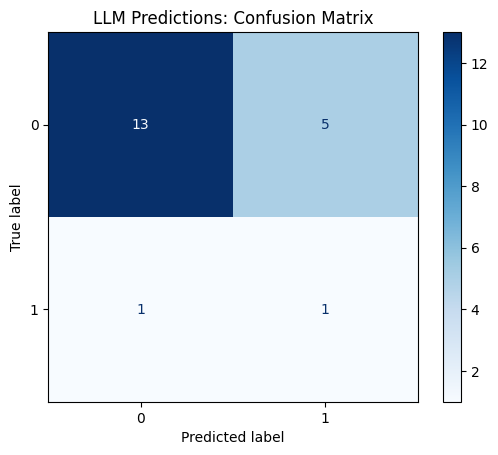

AUROC : 0.3889
AUPRC : 0.0857


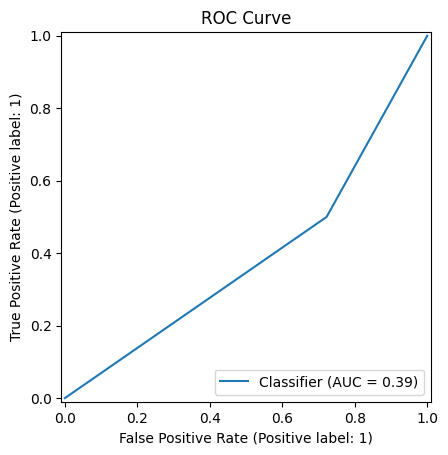

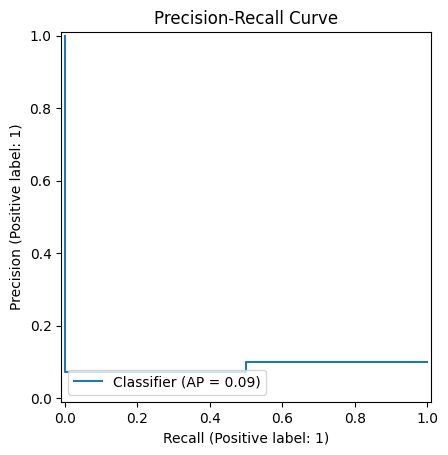

In [10]:
prompt, test_cases, outcomes = build_few_shot_prompt(
    features_a,
    label_col="In-hospital_death_mean",
    scoring=False
)

y_true, y_pred, y_scores = evaluate_llm_predictions(prompt, test_cases, outcomes, model="gemma2:2b", max_cases=20)


## Q4.2 Embedding Task

In [11]:
def get_patient_embedding(text, model='gemma2:2b'):
    response = embeddings(model=model, prompt=text)
    return response['embedding']

def get_all_embeddings(prompt, test_cases, model='gemma2:2b'):
    return [get_patient_embedding(f"{prompt}\n\n{t}", model=model) for t in tqdm(test_cases, desc="Generating embeddings")]

prompt, test_cases, outcomes = build_few_shot_prompt(
    features_a,
    label_col="In-hospital_death_mean",
    scoring=False
)

# # patient_summaries = [generate_patient_summary(row) for _, row in features_a.iterrows()]
# embeddings_list = get_all_embeddings(prompt, test_cases, model='gemma2:2b')

# # Save as DataFrame for probe training
# embedding_df = pd.DataFrame(embeddings_list)

# # Add labels
# embedding_df['label'] = features_a['In-hospital_death_mean'].copy()

# # Save to csv 
# filename = Path(f"embedding_df_Q42.csv")
# embedding_df.to_csv(notebooks_path / data_path / filename)

Generating embeddings:   0%|          | 0/3997 [00:00<?, ?it/s]

In [ ]:
# load embeddings df
filename = Path(f"embedding_df_Q42.csv")
embedding_df = pd.read_csv(notebooks_path / data / path / filename)
del filename